In [1]:
import numpy as np
from numpy.linalg import norm
from scipy.interpolate import BSpline


# =========================================================
# A) True beta generator (ground-truth coefficient functions)
# =========================================================

def default_true_beta_funcs(scales=None):
    """Return a list of callable beta(t) functions."""
    if scales is None:
        scales = [1.0, 1.0, 1.0, 1.0, 1.0]
    return [
        lambda t: scales[0] * (-0.5 + 0.6 * np.cos(2 * np.pi * t)),
        lambda t: scales[1] * (-0.5 + 0.6 * np.cos(2 * np.pi * t)),
        lambda t: scales[2] * (t - 0.5),
        lambda t: scales[3] * (0.7 * np.sin(4 * np.pi * t)),
        lambda t: scales[4] * (0.4 * np.cos(3 * np.pi * t)),
    ]


class VCMSimulator:
    """
    Simulation engine for VCM:
        y = sum_p X_p * beta_p(t) + sigma * eps
    Only p in signal_idx have nonzero beta; others are zero.
    """

    def __init__(self, P: int, signal_idx, beta_funcs, sigma: float,
                 seed_x: int = 0, seed_eps: int = 0, standardize_X: bool = True):
        self.P = int(P)
        self.signal_idx = list(signal_idx)
        self.beta_funcs = list(beta_funcs)
        self.sigma = float(sigma)
        self.standardize_X = bool(standardize_X)

        self.rng_x = np.random.default_rng(seed_x)
        self.rng_eps = np.random.default_rng(seed_eps)

    def sample_segment(self, a: float, b: float, n: int):
        """
        Sample a segment t in [a,b], generate X, y, and beta_true(t) (optional).
        beta_p(t) is evaluated at raw t (NOT normalized).
        """
        t = np.sort(self.rng_x.uniform(a, b, n))
        X = self.rng_x.standard_normal((n, self.P))

        if self.standardize_X:
            X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-12)

        beta_true = np.zeros((n, self.P))
        for j, p in enumerate(self.signal_idx):
            beta_true[:, p] = self.beta_funcs[j % len(self.beta_funcs)](t)

        y = np.sum(X * beta_true, axis=1) + self.sigma * self.rng_eps.standard_normal(n)
        return t, X, y, beta_true


# =========================================================
# B) B-spline / VCM utilities
# =========================================================

def make_open_uniform_knots(a: float, b: float, k: int, n_inner: int) -> np.ndarray:
    inner = np.linspace(a, b, n_inner + 2)[1:-1] if n_inner > 0 else np.array([])
    return np.r_[np.repeat(a, k + 1), inner, np.repeat(b, k + 1)]


def make_global_knots_piecewise(a: float, b: float, k: int, n_inner_per_unit: int) -> np.ndarray:
    """
    Build global knots over [a,b] by unit segments.
    - endpoints clamped (k+1 repeats)
    - interior integer boundaries included once
    - each unit segment has n_inner_per_unit internal knots
    """
    if b <= a:
        raise ValueError("Require b > a.")
    a_int = int(round(a))
    b_int = int(round(b))
    if abs(a - a_int) > 1e-12 or abs(b - b_int) > 1e-12:
        raise ValueError("Assume integer endpoints (0,1,2,...) for simplicity.")

    knots = [*np.repeat(a, k + 1)]
    for s in range(a_int, b_int):
        L, R = float(s), float(s + 1)
        inner = np.linspace(L, R, n_inner_per_unit + 2)[1:-1]
        knots.extend(inner.tolist())
        boundary = float(s + 1)
        if boundary < b:
            knots.append(boundary)
    knots.extend([*np.repeat(b, k + 1)])
    return np.asarray(knots, dtype=float)


def bspline_design_matrix(x: np.ndarray, knots: np.ndarray, k: int) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    m = len(knots) - (k + 1)
    B = np.zeros((len(x), m))
    for j in range(m):
        c = np.zeros(m)
        c[j] = 1.0
        B[:, j] = BSpline(knots, c, k, extrapolate=False)(x)
    B[np.isnan(B)] = 0.0
    return B


def build_vcm_design(B: np.ndarray, X: np.ndarray) -> np.ndarray:
    n, m = B.shape
    P = X.shape[1]
    Phi = np.zeros((n, m * P))
    for p in range(P):
        Phi[:, p * m:(p + 1) * m] = X[:, [p]] * B
    return Phi


def split_blocks(vec: np.ndarray, m: int, P: int):
    return [vec[p * m:(p + 1) * m] for p in range(P)]


def gram_R(knots: np.ndarray, k: int, a: float, b: float, grid: int = 2500) -> np.ndarray:
    gx = np.linspace(a, b, grid)
    B = bspline_design_matrix(gx, knots, k)
    w = np.ones(grid)
    w[0] *= 0.5
    w[-1] *= 0.5
    w *= (b - a) / (grid - 1)
    return B.T @ (B * w[:, None])


def group_weights(B: np.ndarray, X: np.ndarray) -> np.ndarray:
    row_e = np.sum(B * B, axis=1)
    return np.sqrt((X ** 2 * row_e[:, None]).sum(0) / B.shape[0] + 1e-12)


def lambda_max_R(Phi: np.ndarray, y: np.ndarray, m: int, R: np.ndarray) -> float:
    L = np.linalg.cholesky(R)
    P = Phi.shape[1] // m
    lam = 0.0
    for p in range(P):
        g = Phi[:, p * m:(p + 1) * m].T @ y
        u = np.linalg.solve(L.T, g)
        lam = max(lam, float(norm(u)))
    return lam


def group_soft_thresh(blocks, tau: float, R: np.ndarray, lam: float, w: np.ndarray):
    out = []
    for v, wp in zip(blocks, w):
        nr = float(np.sqrt(max(0.0, v.T @ R @ v)))
        thr = tau * lam * wp
        out.append(np.zeros_like(v) if nr <= thr else (1 - thr / nr) * v)
    return out


def fista_group_lasso(XtX: np.ndarray, Xty: np.ndarray, lam: float,
                     m: int, P: int, R: np.ndarray, w: np.ndarray,
                     max_iter: int = 6000, tol: float = 1e-7) -> np.ndarray:
    d = m * P
    Ls = float(np.linalg.norm(XtX, 2))
    Ls = Ls if (np.isfinite(Ls) and Ls > 0) else 1.0
    step = 1.0 / Ls

    c = np.zeros(d)
    z = c.copy()
    tN = 1.0

    for _ in range(max_iter):
        grad = XtX @ z - Xty
        yv = z - step * grad
        yb = split_blocks(yv, m, P)
        c_new = np.concatenate(group_soft_thresh(yb, step, R, lam, w))

        t_new = 0.5 * (1 + np.sqrt(1 + 4 * tN * tN))
        z = c_new + (tN - 1) / t_new * (c_new - c)

        if norm(c_new - c) <= tol * max(1.0, norm(c)):
            return c_new
        c, tN = c_new, t_new

    return c


def kfold_indices(n: int, K: int = 5, seed: int = 2025):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    return np.array_split(idx, K)


def cv_select_lambda_plain(B: np.ndarray, X: np.ndarray, y: np.ndarray,
                          R: np.ndarray, w: np.ndarray, lam_path: np.ndarray,
                          K: int = 5, seed: int = 2025, use_1se: bool = True):
    n = len(y)
    P = X.shape[1]
    m = B.shape[1]
    folds = kfold_indices(n, K, seed)
    mse = np.zeros((len(lam_path), K))

    for li, lam in enumerate(lam_path):
        for kf, val in enumerate(folds):
            tr = np.setdiff1d(np.arange(n), val)
            Btr, Bv = B[tr], B[val]
            Xtr, Xv = X[tr], X[val]
            ytr, yv = y[tr], y[val]

            Phi_tr = build_vcm_design(Btr, Xtr)
            Phi_v = build_vcm_design(Bv, Xv)
            c = fista_group_lasso(Phi_tr.T @ Phi_tr, Phi_tr.T @ ytr,
                                  float(lam), m, P, R, w)
            mse[li, kf] = np.mean((yv - Phi_v @ c) ** 2)

    mm = mse.mean(axis=1)
    best = int(np.argmin(mm))
    if use_1se:
        se = mse.std(axis=1, ddof=1) / np.sqrt(K)
        thr = mm[best] + se[best]
        best = int(np.where(mm <= thr)[0][0])

    return float(lam_path[best])


# =========================================================
# C) Basis mapping and frozen-CV
# =========================================================

def map_unchanged_bases_by_span(knots_old: np.ndarray, knots_new: np.ndarray,
                               k: int, t_cut: float, eps: float = 1e-12):
    """
    Match unchanged bases by knot span equality, restricted to bases fully inside [0, t_cut].
    Returns (idx_old, idx_new) matched pairs.
    """
    t1 = np.asarray(knots_old, dtype=float)
    t2 = np.asarray(knots_new, dtype=float)
    m1 = len(t1) - (k + 1)
    m2 = len(t2) - (k + 1)

    S1 = np.stack([t1[i:i + k + 1] for i in range(m1)], axis=0)
    S2 = np.stack([t2[j:j + k + 1] for j in range(m2)], axis=0)

    cand1 = np.where(S1[:, -1] <= t_cut + eps)[0]
    cand2 = np.where(S2[:, -1] <= t_cut + eps)[0]

    pairs = []
    for i in cand1:
        a = S1[i]
        hit = np.where(np.all(np.abs(S2[cand2] - a) < eps, axis=1))[0]
        if hit.size == 1:
            pairs.append((int(i), int(cand2[hit[0]])))

    if not pairs:
        return np.array([], dtype=int), np.array([], dtype=int)

    idx_old, idx_new = zip(*pairs)
    return np.asarray(idx_old, dtype=int), np.asarray(idx_new, dtype=int)


def relax_near_boundary(idx_new_matched: np.ndarray, knots_new: np.ndarray, k: int, r_relax: int):
    """Release r_relax bases closest to the boundary from freezing."""
    if r_relax <= 0 or len(idx_new_matched) <= r_relax:
        keep = np.ones_like(idx_new_matched, dtype=bool)
        return idx_new_matched[keep], idx_new_matched[~keep]

    right_end = np.array([knots_new[j + k] for j in idx_new_matched], dtype=float)
    order = np.argsort(right_end)
    move = np.zeros_like(idx_new_matched, dtype=bool)
    move[order[-r_relax:]] = True

    return idx_new_matched[~move], idx_new_matched[move]


def cv_select_lambda_frozen(B_full: np.ndarray, X: np.ndarray, y: np.ndarray,
                            R_full: np.ndarray, lambdas: np.ndarray,
                            idx_o: np.ndarray, c_o_mat: np.ndarray,
                            K: int = 5, seed: int = 2025, use_1se: bool = True):
    n_all, m_full = B_full.shape
    P = X.shape[1]
    folds = kfold_indices(n_all, K, seed)

    idx_all = np.arange(m_full, dtype=int)
    idx_cn = np.setdiff1d(idx_all, idx_o)

    mse = np.zeros((len(lambdas), K))

    for li, lam in enumerate(lambdas):
        for kf, val in enumerate(folds):
            tr = np.setdiff1d(np.arange(n_all), val)

            Btr, Bv = B_full[tr], B_full[val]
            Xtr, Xv = X[tr], X[val]
            ytr, yv = y[tr], y[val]

            Btr_o, Bv_o = Btr[:, idx_o], Bv[:, idx_o]
            Btr_cn, Bv_cn = Btr[:, idx_cn], Bv[:, idx_cn]

            frozen_tr = np.sum(Xtr * (Btr_o @ c_o_mat.T), axis=1)
            frozen_v = np.sum(Xv * (Bv_o @ c_o_mat.T), axis=1)

            ytr_res = ytr - frozen_tr

            R_cn = R_full[np.ix_(idx_cn, idx_cn)]
            w_cn = group_weights(Btr_cn, Xtr)

            Phi_tr = build_vcm_design(Btr_cn, Xtr)
            Phi_v = build_vcm_design(Bv_cn, Xv)

            c_cn = fista_group_lasso(Phi_tr.T @ Phi_tr, Phi_tr.T @ ytr_res,
                                     float(lam), Btr_cn.shape[1], P, R_cn, w_cn)
            y_pred = frozen_v + Phi_v @ c_cn
            mse[li, kf] = np.mean((yv - y_pred) ** 2)

    mm = mse.mean(axis=1)
    best = int(np.argmin(mm))
    if use_1se:
        se = mse.std(axis=1, ddof=1) / np.sqrt(K)
        thr = mm[best] + se[best]
        best = int(np.where(mm <= thr)[0][0])

    return float(lambdas[best])


def adaptive_cn_refit(B_cn: np.ndarray, X: np.ndarray, y_res: np.ndarray,
                      R_cn: np.ndarray, lam_path: np.ndarray,
                      seed_cv: int, use_1se: bool, eps: float = 1e-6, delta: float = 1.0):
    """
    One-step adaptive group-lasso on CN subspace:
    - Warm fit (weak penalty) -> r0 -> w_ad
    - CV over lam_path with w_ad
    - Final refit
    """
    n = len(y_res)
    P = X.shape[1]
    m_cn = B_cn.shape[1]

    Phi = build_vcm_design(B_cn, X)

    # Warm solution: use weak penalty
    lam_warm = float(lam_path[-1])
    c0 = fista_group_lasso(Phi.T @ Phi, Phi.T @ y_res,
                           lam_warm, m_cn, P, R_cn, group_weights(B_cn, X))

    blocks0 = split_blocks(c0, m_cn, P)
    r0 = np.array([float(np.sqrt(max(0.0, b.T @ R_cn @ b))) for b in blocks0])
    w_ad = 1.0 / (r0 + eps) ** delta

    folds = kfold_indices(n, K=5, seed=seed_cv)
    mse = np.zeros((len(lam_path), 5))

    for li, lam in enumerate(lam_path):
        for kf, val in enumerate(folds):
            tr = np.setdiff1d(np.arange(n), val)
            Btr, Bv = B_cn[tr], B_cn[val]
            Xtr, Xv = X[tr], X[val]
            ytr, yv = y_res[tr], y_res[val]

            Phi_tr = build_vcm_design(Btr, Xtr)
            Phi_v = build_vcm_design(Bv, Xv)

            c_tmp = fista_group_lasso(Phi_tr.T @ Phi_tr, Phi_tr.T @ ytr,
                                      float(lam), m_cn, P, R_cn, w_ad)
            mse[li, kf] = np.mean((yv - Phi_v @ c_tmp) ** 2)

    mm = mse.mean(axis=1)
    best = int(np.argmin(mm))
    if use_1se:
        se = mse.std(axis=1, ddof=1) / np.sqrt(5)
        thr = mm[best] + se[best]
        best = int(np.where(mm <= thr)[0][0])

    lam_best = float(lam_path[best])
    c_final = fista_group_lasso(Phi.T @ Phi, Phi.T @ y_res, lam_best, m_cn, P, R_cn, w_ad)
    return lam_best, c_final


# =========================================================
# D) Incremental trainer (stateful) + end-to-end simulation loop
# =========================================================

class IncrementalVCMTrainer:
    """
    Stateful incremental trainer that supports:
    - initial fit on [0, 1]
    - extend to [0, 2], [0, 3], ... with freezing O and solving CN
    """

    def __init__(self, k: int, n_inner_per_unit: int, P: int,
                 seed_cv: int = 2025, use_1se: bool = True,
                 r_relax: int = 2):
        self.k = int(k)
        self.n_inner_per_unit = int(n_inner_per_unit)
        self.P = int(P)
        self.seed_cv = int(seed_cv)
        self.use_1se = bool(use_1se)
        self.r_relax = int(r_relax)

        # State
        self.t_end = None
        self.knots = None
        self.coef_blocks = None

        # Data cache
        self.t_all = None
        self.X_all = None
        self.y_all = None

    def fit_initial(self, t: np.ndarray, X: np.ndarray, y: np.ndarray, t_end: float):
        self.t_end = float(t_end)
        self.t_all = np.asarray(t, dtype=float).copy()
        self.X_all = np.asarray(X, dtype=float).copy()
        self.y_all = np.asarray(y, dtype=float).copy()

        knots = make_open_uniform_knots(0.0, self.t_end, self.k, self.n_inner_per_unit)
        B = bspline_design_matrix(self.t_all, knots, self.k)
        m = B.shape[1]

        Phi = build_vcm_design(B, self.X_all)
        R = gram_R(knots, self.k, 0.0, self.t_end)
        w = group_weights(B, self.X_all)

        lam_max = lambda_max_R(Phi, self.y_all, m, R)
        lam_path = np.geomspace(lam_max, lam_max * 5e-4, 30)
        lam_best = cv_select_lambda_plain(B, self.X_all, self.y_all, R, w, lam_path,
                                          K=5, seed=self.seed_cv, use_1se=self.use_1se)

        c = fista_group_lasso(Phi.T @ Phi, Phi.T @ self.y_all, lam_best, m, self.P, R, w)
        self.knots = knots
        self.coef_blocks = split_blocks(c, m, self.P)

        return {"t_end": self.t_end, "m": m, "lambda": float(lam_best)}

    def extend_to(self, t_new: float, t_seg: np.ndarray, X_seg: np.ndarray, y_seg: np.ndarray,
                  use_adaptive_cn: bool = True):
        t_new = float(t_new)
        if t_new <= self.t_end + 1e-12:
            raise ValueError("t_new must be greater than current t_end.")

        # Append new data
        self.t_all = np.r_[self.t_all, np.asarray(t_seg, dtype=float)]
        self.X_all = np.vstack([self.X_all, np.asarray(X_seg, dtype=float)])
        self.y_all = np.r_[self.y_all, np.asarray(y_seg, dtype=float)]

        # New knots over [0, t_new]
        knots_new = make_global_knots_piecewise(0.0, t_new, self.k, self.n_inner_per_unit)
        B_full = bspline_design_matrix(self.t_all, knots_new, self.k)
        m_full = B_full.shape[1]

        # Map unchanged O up to old boundary self.t_end
        idx_old, idx_new_matched = map_unchanged_bases_by_span(self.knots, knots_new, self.k, t_cut=self.t_end)

        # Relax near boundary
        idx_new_o, idx_new_relaxed = relax_near_boundary(idx_new_matched, knots_new, self.k, self.r_relax)

        # Filter idx_old to match idx_new_o
        new2old = {int(j): int(i) for i, j in zip(idx_old.tolist(), idx_new_matched.tolist())}
        idx_old_o = np.array([new2old[int(j)] for j in idx_new_o], dtype=int)

        # O/CN split in new basis
        idx_all = np.arange(m_full, dtype=int)
        idx_o = idx_new_o
        idx_cn = np.setdiff1d(idx_all, idx_o)

        # Frozen coefficient matrix (P, |O|)
        c_o_mat = np.stack([self.coef_blocks[p][idx_old_o].astype(float, copy=True)
                            for p in range(self.P)], axis=0)

        # Frozen contribution + residual
        B_o = B_full[:, idx_o]
        frozen_y = np.sum(self.X_all * (B_o @ c_o_mat.T), axis=1)
        y_res = self.y_all - frozen_y

        # CN subproblem
        B_cn = B_full[:, idx_cn]
        R_full = gram_R(knots_new, self.k, 0.0, t_new)
        R_cn = R_full[np.ix_(idx_cn, idx_cn)]
        Phi_cn = build_vcm_design(B_cn, self.X_all)

        lam2_max = lambda_max_R(Phi_cn, y_res, B_cn.shape[1], R_cn)
        lam_path = np.geomspace(lam2_max, lam2_max * 5e-4, 30)

        # Frozen CV select
        lam_best = cv_select_lambda_frozen(B_full, self.X_all, self.y_all,
                                           R_full, lam_path, idx_o, c_o_mat,
                                           K=5, seed=self.seed_cv, use_1se=self.use_1se)

        # Fit CN
        w_cn = group_weights(B_cn, self.X_all)
        c_cn = fista_group_lasso(Phi_cn.T @ Phi_cn, Phi_cn.T @ y_res,
                                 lam_best, B_cn.shape[1], self.P, R_cn, w_cn)

        # Optional adaptive on CN
        lam_ad = None
        c_cn_use = c_cn
        if use_adaptive_cn:
            lam_ad, c_cn_use = adaptive_cn_refit(B_cn, self.X_all, y_res, R_cn,
                                                 lam_path=lam_path, seed_cv=self.seed_cv,
                                                 use_1se=self.use_1se)

        # Reassemble full coefficients in new basis
        blocks_cn = split_blocks(c_cn_use, B_cn.shape[1], self.P)
        coef_blocks_new = []
        for p in range(self.P):
            c_full = np.zeros(m_full, dtype=float)
            c_full[idx_o] = c_o_mat[p]
            c_full[idx_cn] = blocks_cn[p]
            coef_blocks_new.append(c_full)

        # Update state
        self.t_end = t_new
        self.knots = knots_new
        self.coef_blocks = coef_blocks_new

        # Diagnostics
        yhat = self.predict(self.t_all, self.X_all)
        rmse = float(np.sqrt(np.mean((self.y_all - yhat) ** 2)))
        return {
            "t_end": self.t_end,
            "m_full": int(m_full),
            "num_frozen": int(len(idx_o)),
            "num_cn": int(len(idx_cn)),
            "lambda_cn": float(lam_best),
            "lambda_cn_ad": (float(lam_ad) if lam_ad is not None else None),
            "train_rmse": rmse,
            "relaxed_count": int(len(idx_new_relaxed)),
        }

    def predict(self, t: np.ndarray, X: np.ndarray) -> np.ndarray:
        t = np.asarray(t, dtype=float)
        X = np.asarray(X, dtype=float)
        B = bspline_design_matrix(t, self.knots, self.k)
        beta_hat = np.column_stack([B @ self.coef_blocks[p] for p in range(self.P)])
        return np.sum(X * beta_hat, axis=1)

    def eval_beta(self, t_grid: np.ndarray) -> np.ndarray:
        t_grid = np.asarray(t_grid, dtype=float)
        B = bspline_design_matrix(t_grid, self.knots, self.k)
        return np.column_stack([B @ self.coef_blocks[p] for p in range(self.P)])


def run_incremental_simulation(
    t_final: float,
    segment_length: float,
    n_per_segment: int,
    P: int,
    signal_idx,
    beta_funcs,
    sigma: float,
    k: int,
    n_inner_per_unit: int,
    seed_data: int = 0,
    seed_cv: int = 2025,
    use_1se: bool = True,
    r_relax: int = 2,
    use_adaptive_cn: bool = True,
):
    """
    End-to-end simulation:
    - segment 0: [0,1] -> initial fit
    - segment s: [s, s+1] -> generate data and extend fit
    """
    if abs(segment_length - 1.0) > 1e-12:
        raise ValueError("For now, segment_length must be 1.0 to match integer boundary knots.")

    sim = VCMSimulator(
        P=P, signal_idx=signal_idx, beta_funcs=beta_funcs, sigma=sigma,
        seed_x=seed_data, seed_eps=seed_data + 12345
    )

    trainer = IncrementalVCMTrainer(
        k=k, n_inner_per_unit=n_inner_per_unit, P=P,
        seed_cv=seed_cv, use_1se=use_1se, r_relax=r_relax
    )

    # --- Segment 0: [0,1] ---
    t0, X0, y0, beta0 = sim.sample_segment(0.0, 1.0, n_per_segment)
    info0 = trainer.fit_initial(t0, X0, y0, t_end=1.0)

    history = [{"stage": 1, "interval": (0.0, 1.0), **info0}]
    data_cache = {
        "t": [t0], "X": [X0], "y": [y0], "beta_true": [beta0]
    }

    # --- Extend to [0,2], [0,3], ... ---
    current_end = 1.0
    stage = 2
    while current_end < t_final - 1e-12:
        next_end = current_end + segment_length
        if next_end > t_final + 1e-12:
            raise ValueError("t_final must be integer multiple of segment_length in this version.")

        t_seg, X_seg, y_seg, beta_seg = sim.sample_segment(current_end, next_end, n_per_segment)
        info = trainer.extend_to(next_end, t_seg, X_seg, y_seg, use_adaptive_cn=use_adaptive_cn)

        history.append({"stage": stage, "interval": (0.0, next_end), **info})
        data_cache["t"].append(t_seg)
        data_cache["X"].append(X_seg)
        data_cache["y"].append(y_seg)
        data_cache["beta_true"].append(beta_seg)

        current_end = next_end
        stage += 1

    return trainer, history, data_cache


In [7]:
P = 100
signal_idx = [1,2,3,4,5]
beta_funcs = default_true_beta_funcs()
sigma = 0.1

trainer, history, data_cache = run_incremental_simulation(
    t_final=4.0,
    segment_length=1.0,
    n_per_segment=400,
    P=P,
    signal_idx=signal_idx,
    beta_funcs=beta_funcs,
    sigma=sigma,
    k=3,
    n_inner_per_unit=10,
    seed_data=0,
    seed_cv=2025,
    use_1se=True,
    r_relax=2,
    use_adaptive_cn=True
)

for h in history:
    print(h)


{'stage': 1, 'interval': (0.0, 1.0), 't_end': 1.0, 'm': 14, 'lambda': 0.6941202557151723}
{'stage': 2, 'interval': (0.0, 2.0), 't_end': 2.0, 'm_full': 25, 'num_frozen': 10, 'num_cn': 15, 'lambda_cn': 0.8720893740298815, 'lambda_cn_ad': 0.23518948014545898, 'train_rmse': 0.10104477709203463, 'relaxed_count': 2}
{'stage': 3, 'interval': (0.0, 3.0), 't_end': 3.0, 'm_full': 36, 'num_frozen': 21, 'num_cn': 15, 'lambda_cn': 0.970362569161234, 'lambda_cn_ad': 0.4420263651074764, 'train_rmse': 0.10958881503783682, 'relaxed_count': 2}
{'stage': 4, 'interval': (0.0, 4.0), 't_end': 4.0, 'm_full': 47, 'num_frozen': 32, 'num_cn': 15, 'lambda_cn': 1.1758648133084233, 'lambda_cn_ad': 0.6961457139583943, 'train_rmse': 0.12197299929056628, 'relaxed_count': 2}


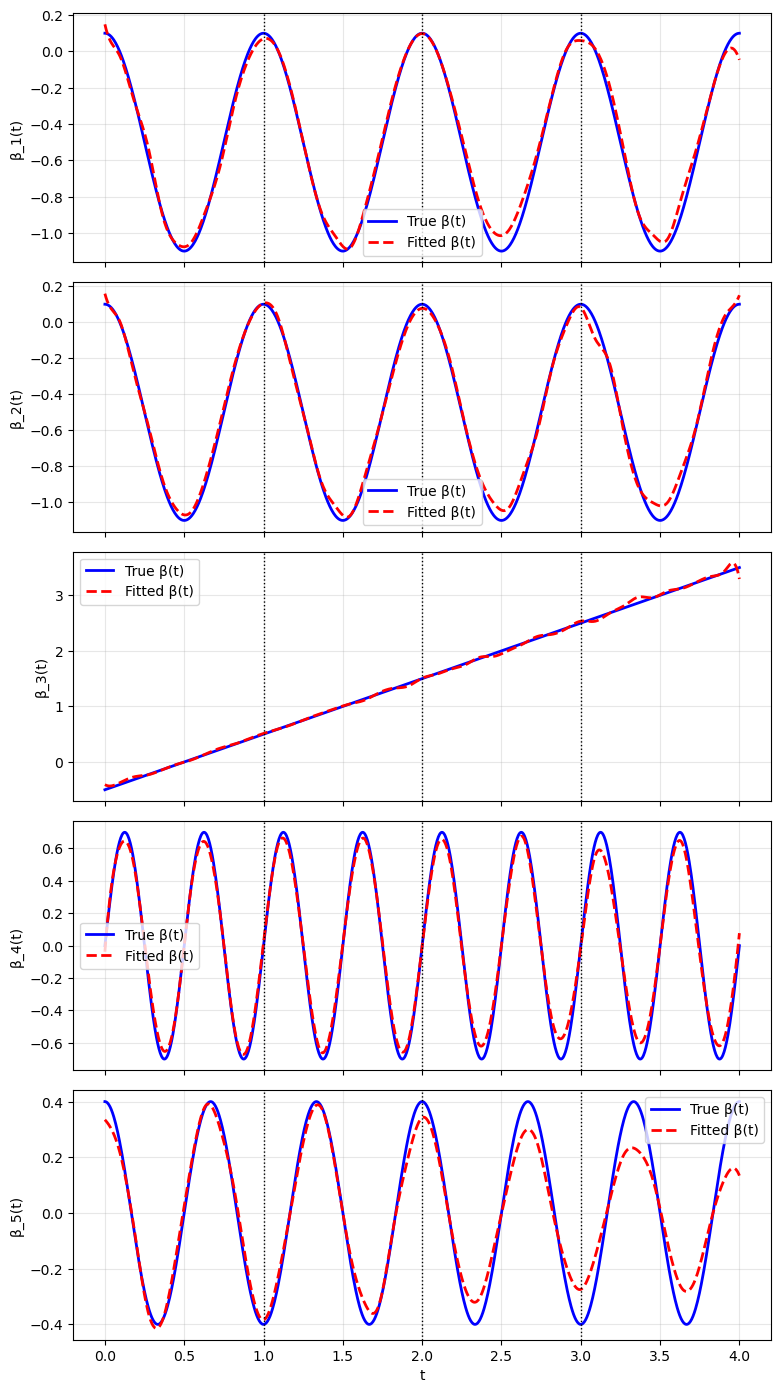

In [8]:
import matplotlib.pyplot as plt

t_grid = np.linspace(0, 4, 1000)
beta_hat = trainer.eval_beta(t_grid)

# True beta
beta_true = np.zeros_like(beta_hat)
for j, p in enumerate(signal_idx):
    beta_true[:, p] = beta_funcs[j % len(beta_funcs)](t_grid)

r = min(len(signal_idx), 5)
fig, axs = plt.subplots(r, 1, figsize=(8, 2.2*r+3), sharex=True)
for ax, p in zip(axs, signal_idx[:r]):
    ax.plot(t_grid, beta_true[:, p], 'b', lw=2, label='True β(t)')
    ax.plot(t_grid, beta_hat[:, p], 'r--', lw=2, label='Fitted β(t)')
    for cut in range(1, 4):
        ax.axvline(cut, color='k', ls=':', lw=1)
    ax.set_ylabel(f"β_{p}(t)")
    ax.grid(alpha=0.3)
    ax.legend(loc='best')
axs[-1].set_xlabel("t")
plt.tight_layout()
plt.show()
